# Interpretable Approximation 

Fit the black-box model (e.g. deep neural network) predictions and data with a simpler and interpretable model (e.g. decision tree). The "white-box" model provides an approximation of the original one and, thus, it can be used to extract insights and knowledge about the full-fledged but less interpretable model. 

In [1]:
import xarray as xr
import netCDF4
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import gc
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import box
from affine import Affine
import sys
import seaborn as sns
import rasterio
import os
from collections import defaultdict
import random
from methods.interpretable_approximation import WhiteBox 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_precision_recall_curve

In [2]:
import warnings
warnings.filterwarnings('ignore')

Upload UC3 data: 

In [3]:
df = pd.read_csv(r"C:\Users\unknown\Desktop\repos\DC\data\greece_pixel_dataset.csv")

In [4]:
list(df.columns)

['Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
 'x',
 'y',
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc',
 'burned_areas',
 'time',
 'datetime']

In [5]:
features = [
 'Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp'
]

coordinates = ['x', 'y']

static_features = [ 
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc'
]

target = 'burned_areas'

Data cleaning and train-test splitting: 

In [6]:
nan_fillvalue = -9999
df = df.fillna(nan_fillvalue)
time_split = int(df.time.max()*0.85)
train_df=df[df['time']<time_split]
test_df=df[df['time']>=time_split]

Fit a Random Forest and plot results: 

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2050
         1.0       0.73      0.62      0.67       634

    accuracy                           0.86      2684
   macro avg       0.81      0.77      0.79      2684
weighted avg       0.85      0.86      0.85      2684



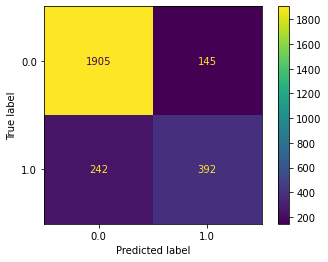

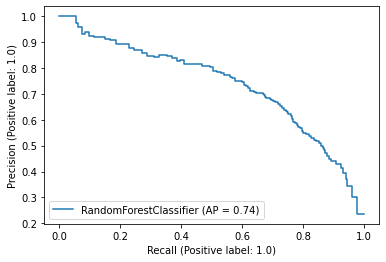

In [7]:
features_to_exclude = [
 'Fpar_500m',
 'Lai_500m',
#  'LST_Day_1km',
#  'LST_Night_1km',
#  '1 km 16 days NDVI',
#  '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
#  'era5_max_u10',
#  'era5_max_v10',
#  'era5_max_t2m',
#  'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
#  'dem_mean',
 'dem_std',
#  'aspect_mean',
 'aspect_std',
#  'slope_mean',
#  'slope_std',
#  'roads_density_2020',
#  'population_density',
#  'clc'
]
features_filtered = [x for x in features + static_features if x not in features_to_exclude]

X_train, X_test = train_df[features_filtered], test_df[features_filtered]
y_train, y_test = train_df[target], test_df[target]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()
plot_precision_recall_curve(clf, X_test, y_test)  
plt.show()

Let us now fit an interpretable model in order to get an approximation of the black-box model and, thanks to that, obtain information on the original model:

In [8]:
features_filtered

['LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'dem_mean',
 'aspect_mean',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc']

In [9]:
config = {
    "model": clf,
    "X": np.array(X_train), 
    "features":features_filtered,
    "approximator": "logistic"
}

In [10]:
wb = WhiteBox(config)
mod_approx = wb.fit()

Let us plot the results: 

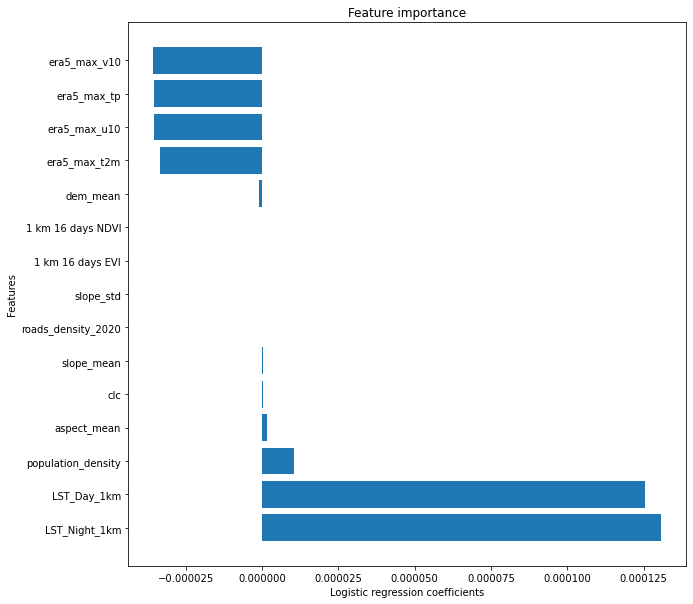

In [11]:
wb.plot(mod_approx)

We can also call the run_all() method if we want to fit the white box model and show the results at the same time:

White box model approximates black box with accuracy =  0.7101503292334451


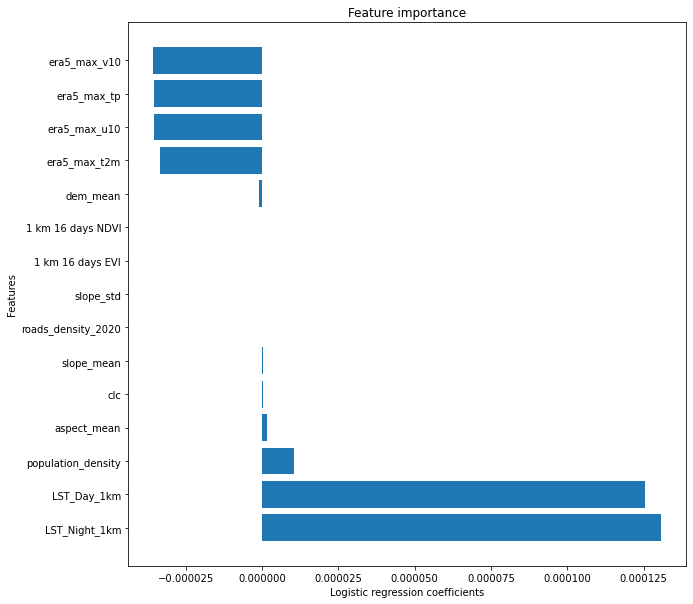

In [12]:
wb.run_all()

Let us now try to approximate the model with a decision tree: 

In [13]:
config = {
    "model": clf,
    "X": np.array(X_train), 
    "features":features_filtered,
    "approximator": "tree", 
    "iterations": 200,
    "classes": ["No Fire", "Fire"], 
    "instance":0
}

White box model approximates black box with accuracy =  0.8397937632003976
The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if era5_max_tp <= 5.736947059631348e-06 else to node 4.
	node=1 is a split node: go to node 2 if LST_Day_1km <= 301.9300079345703 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if LST_Day_1km <= 307.8699951171875 else to node 6.
		node=5 is a leaf node.
		node=6 is a leaf node.


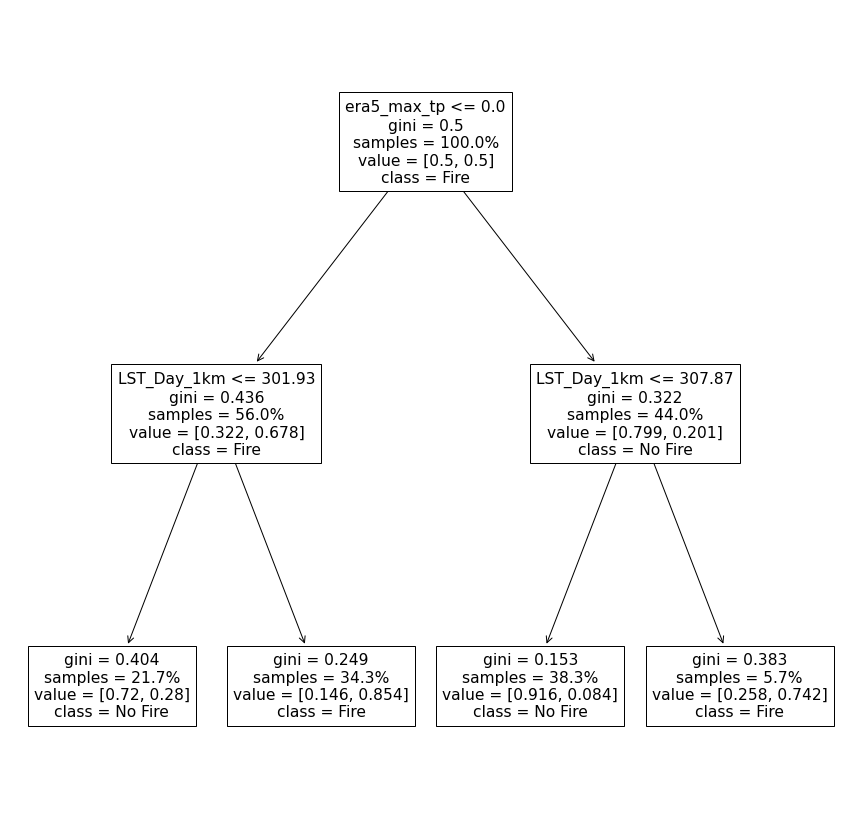

Rules used to predict sample 0:

Instance number :  0
LST_Day_1km  =  -9999.0
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  44050000.0
1 km 16 days EVI  =  23060000.0
era5_max_u10  =  0.79484916
era5_max_v10  =  0.31691074
era5_max_t2m  =  280.3381
era5_max_tp  =  0.0016517565
dem_mean  =  582.0038
aspect_mean  =  157.80649
slope_mean  =  8.457027
slope_std  =  4.7070537
roads_density_2020  =  0.0
population_density  =  -9999.0
clc  =  26.0
decision node 0 : (era5_max_tp = 0.0016517565) > 5.736947059631348e-06)
decision node 4 : (LST_Day_1km = -9999.0) <= 307.8699951171875)


In [14]:
wb = WhiteBox(config)
wb.run_all()